### Realizamos la carga de los datos

In [ ]:
#-- Descomprimimos el dataset
!rm -r mnist
!unzip mnist.zip

In [4]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

In [6]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [7]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [8]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [9]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [10]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

### Definimos la matriz de confusión

In [26]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  return fig

### Metaparametros a estudiar
- **n_epoch** = Número de épocas
- **lr** = Tasa de aprendizaje 
- **weight_decay** = peso de decaímiento
- **batch_size** = Tamaño del subconjunto


#### Según un modelo que suponemos ya creado, definimos el ciclo de aprendizaje

In [27]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  matrix = CM(Y_valid, Y_pred, 10)
  return f1_valid[-1], matrix

#### Definimos la lista de los metaparámetros, creamos el primer modelo con 100 neuronas ocultas y 5 capas, y corremos su aprendizaje evaluándolo con la matriz de confusión.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

ne_list = [50,100,150]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
bs_list = [256,512,1024]

dict_f1 = {}      #Definimos un dict_f1 para guardar el f1 de cada modelo y luego encontrar rápidamente el que tiene un mejor aprendizaje

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 100

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        f1, matrix = train_valid(model,ne,optimizer,criterion)
        print('###################\n')
        pbar.update()

      dict_f1[f1] = [ne, lr, wd, bs, matrix]
pbar.close()

### Utilizamos el diccionario para hallar los parámetros y la matrix de confusión del f1 máximo

f1_max:0.9229, n_epoch:150, lr:0.001, weight_decay:0.1, batch_size:512 


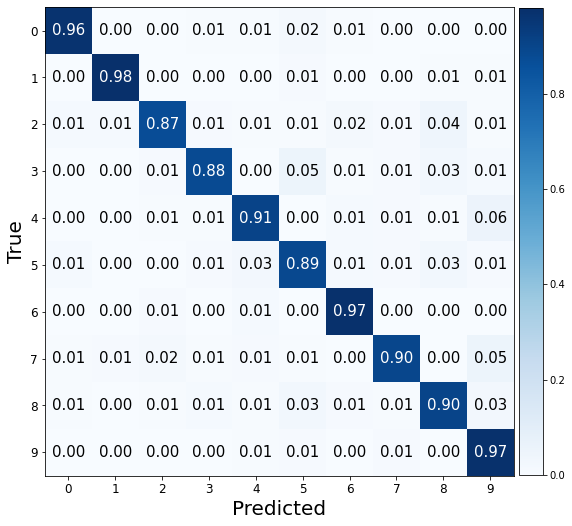

In [39]:
#Llamamos al máximo de f1_dict

f1_max = max(dict_f1.keys())
print("f1_max:{:.4f}, n_epoch:{}, lr:{}, weight_decay:{}, batch_size:{} ".format(f1_max,*dict_f1[f1_max][:4]))

dict_f1[f1_max][-1]

Creamos ahora el segundo modelo con 50 neuronas ocultas y 3 capas, y corremos su aprendizaje evaluándolo con la matriz de confusión.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

ne_list = [50,100,150]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
bs_list = [256,512,1024]

dict_f1 = {}      #Definimos un dict_f1 para guardar el f1 de cada modelo y luego encontrar rápidamente el que tiene un mejor aprendizaje

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 50

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        f1, matrix = train_valid(model,ne,optimizer,criterion)
        print('###################\n')
        pbar.update()

      dict_f1[f1] = [ne, lr, wd, bs, matrix]
pbar.close()

f1_max:0.8733, n_epoch:100, lr:0.001, weight_decay:0.1, batch_size:512 


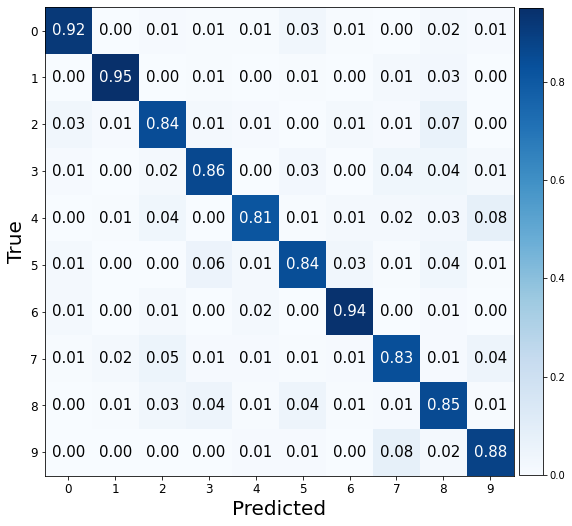

In [41]:
#Llamamos al máximo de f1_dict

f1_max = max(dict_f1.keys())
print("f1_max:{:.4f}, n_epoch:{}, lr:{}, weight_decay:{}, batch_size:{} ".format(f1_max,*dict_f1[f1_max][:4]))

dict_f1[f1_max][-1]

### Tenemos entonces los siguientes datos
- Modelo 1: 100 neuronas ocultas y 5 capas  
f1_max:0.9229, n_epoch:150, lr:0.001, weight_decay:0.1, batch_size:512    
- Modelo 2: 50 neuronas ocultas y 3 capas  
f1_max:0.8733, n_epoch:100, lr:0.001, weight_decay:0.1, batch_size:512  


#### Cuyas matrices de confusión se ven en el código anterior. De estos dos modelos podemos concluir que, pese a utilizar mayor número de épocas, el primero, con más neuronas y más capas, consigue un mejor f1 con una diferencia significativa del 5%. Esto nos lleva a concluir que, si tenemos el espacio y el poder suficiente, podemos conseguir mejores resultados. Adicional a esto, el parámetro weight_decay nos ayuda a no caer en el sobreajuste.
